*** Use Transfer Learning(YamNet) with RandomForest firstly, and secondly use self supervised learning ***

1. Transfer Learning and RandomForest

In [ ]:
!pip uninstall -y librosa resampy lazy_loader

Found existing installation: librosa 0.11.0
Uninstalling librosa-0.11.0:
  Successfully uninstalled librosa-0.11.0
Found existing installation: resampy 0.4.3
Uninstalling resampy-0.4.3:
  Successfully uninstalled resampy-0.4.3
Found existing installation: lazy_loader 0.4
Uninstalling lazy_loader-0.4:
  Successfully uninstalled lazy_loader-0.4


In [ ]:
!pip install librosa==0.10.1 resampy==0.4.3 soundfile==0.12.1

  Using cached resampy-0.4.3-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 9.9 MB/s eta 0:00:00
Using cached resampy-0.4.3-py3-none-any.whl (3.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.5 MB/s eta 0:00:00
  Attempting uninstall: soundfile
    Found existing installation: soundfile 0.13.1
    Uninstalling soundfile-0.13.1:
      Successfully uninstalled soundfile-0.13.1


In [ ]:
# Install necessary libraries (Execute in Google Colab environment)
#!pip install librosa
!pip install scikit-learn
# Download the ESC-50 dataset
!wget https://github.com/karolpiczak/ESC-50/archive/master.zip -O ESC-50.zip
!unzip ESC-50.zip
!mv ESC-50-master ESC-50_data

--2025-11-04 00:15:30--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-11-04 00:15:30--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.116.10
Connecting to codeload.github.com (codeload.github.com)|140.82.116.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘ESC-50.zip’

ESC-50.zip              [           <=>      ] 615.78M  14.5MB/s    in 40s     

2025-11-04 00:16:10 (15.5 MB/s) - ‘ESC-50.zip’ saved [645695005]

Archive:  ESC-50.zip
33c8ce9eb2cf0b1c2f8bcf322eb349b6be34dbb6
   creating: ESC-50-master/
   creating: ESC-50-master/.circleci/
  inflating: ESC-50-

In [ ]:
!pip -q install soundfile tensorflow tensorflow_hub scikit-learn pandas
#!pip -q install librosa
import os, numpy as np, pandas as pd, librosa, soundfile as sf, pathlib
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

# ESC-50 Meta Data & Autio Data
META_CSV = 'ESC-50_data/meta/esc50.csv'
AUDIO_DIR = 'ESC-50_data/audio'
df = pd.read_csv(META_CSV)
print(df.head(10))

            filename  fold  target         category  esc10  src_file take
0   1-100032-A-0.wav     1       0              dog   True    100032    A
1  1-100038-A-14.wav     1      14   chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36   vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36   vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19     thunderstorm  False    101296    A
5  1-101296-B-19.wav     1      19     thunderstorm  False    101296    B
6  1-101336-A-30.wav     1      30  door_wood_knock  False    101336    A
7  1-101404-A-34.wav     1      34      can_opening  False    101404    A
8   1-103298-A-9.wav     1       9             crow  False    103298    A
9  1-103995-A-30.wav     1      30  door_wood_knock  False    103995    A


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

### Transfer Learing with YamNet
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")

def load_audio_16k_mono(path, target_sr=16000):
    y, sr = sf.read(path, dtype='float32', always_2d=False)
    if y.ndim > 1:
        y = np.mean(y, axis=1)  # mono
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_fast")
        sr = target_sr
    # YAMNet: -1~1 float32
    y = np.clip(y, -1.0, 1.0).astype(np.float32)
    return y, sr

@tf.function
def yamnet_forward(waveform_1d):
    # waveform_1d: tf.Tensor [n_samples], float32
    scores, embeddings, spectrogram = yamnet(waveform_1d)
    return embeddings  # [frames, 1024]

def yamnet_embedding(path):
    y, sr = load_audio_16k_mono(path, 16000)
    wf = tf.convert_to_tensor(y, dtype=tf.float32)
    embs = yamnet_forward(wf).numpy()           # (T, 1024)
    # Time pooling: mean + std → (2048,)
    feat = np.hstack([embs.mean(axis=0), embs.std(axis=0)])
    return feat

In [ ]:
X_yam, y_label, groups = [], [], []

cache_dir = pathlib.Path('/content/yamnet_cache'); cache_dir.mkdir(exist_ok=True)

for _, row in tqdm(df.iterrows(), total=len(df)):
    wav = os.path.join(AUDIO_DIR, row['filename'])
    npy_path = cache_dir / (row['filename'].replace('.wav', '.npy'))

    if npy_path.exists():
        feat = np.load(npy_path)
    else:
        feat = yamnet_embedding(wav)
        np.save(npy_path, feat)

    X_yam.append(feat)
    y_label.append(row['category'])
    groups.append(row['fold'])

X_yam = np.vstack(X_yam)
y_label = np.array(y_label)
groups = np.array(groups)
print("YAMNet feature shape:", X_yam.shape)


100%|██████████| 2000/2000 [03:44<00:00,  8.92it/s]

YAMNet feature shape: (2000, 2048)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y_label)

### Install
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pathlib
### Split ESC-50 data into Train set/Validation Set / Test Set
folds = groups.astype(int)
train_mask = np.isin(folds, [1, 2, 3]) # 1,2,3 fold => Train Set
val_mask   = (folds == 4) # 4 fold => Validation Set
test_mask  = (folds == 5) # 5 fold => Test Set

X_train, y_train = X_yam[train_mask], y_enc[train_mask]
X_val,   y_val   = X_yam[val_mask],   y_enc[val_mask]
X_test0, y_test0 = X_yam[test_mask],  y_enc[test_mask]

print("Train:", X_train.shape, " Val:", X_val.shape, " Test(all):", X_test0.shape)

### Inference Set from the test Set
inference_ratio = 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=inference_ratio, random_state=42)
test_idx = np.arange(len(X_test0))
test_keep_idx, inf_idx = next(sss.split(X_test0, y_test0))

X_test,  y_test  = X_test0[test_keep_idx], y_test0[test_keep_idx]
X_infer, y_infer = X_test0[inf_idx],       y_test0[inf_idx]

print("Final Split → Train:", X_train.shape,
      " Val:", X_val.shape,
      " Test:", X_test.shape,
      " Inference:", X_infer.shape)

### Feature Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)
X_inf_s   = scaler.transform(X_infer)

###Train Random Forest Classifier..

clf = RandomForestClassifier( #rf
    n_estimators=600,
    max_depth=None,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
### Training: Through it, the internal parameter(clf.extimators_) are made.
train_pred = clf.fit(X_train_s, y_train)

#train_acc  = accuracy_score(y_val,  train_pred)
#train_f1   = f1_score(y_train,  train_pred, average="macro")
#print(f"[YAMNet+RF] Train ACC: {train_acc:.3f}, Macro-F1: {train_f1:.3f}")
#print("\n[Train REPORT]\n",  classification_report(y_train,  train_pred,  target_names=le.classes_))

"""
gkf = GroupKFold(n_splits=5)
accs, f1s = [], []
for (tr_idx, te_idx) in gkf.split(X_yam, y_enc, groups):
    rf.fit(X_yam[tr_idx], y_enc[tr_idx])
    pred = rf.predict(X_yam[te_idx])
    accs.append(accuracy_score(y_enc[te_idx], pred))
    f1s.append(f1_score(y_enc[te_idx], pred, average="macro"))

print(f"[YamNet+RandomF] 5-Fold ACC: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"[YamNet+RandomF] 5-Fold Macro-F1: {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
"""
###Validation & Testing
val_pred  = clf.predict(X_val_s)
val_acc  = accuracy_score(y_val,  val_pred)
val_f1   = f1_score(y_val,  val_pred, average="macro")
print(f"[YamNet+RandomF] Validation ACC: {val_acc:.3f}, Macro-F1: {val_f1:.3f}")
print("\n[Validation]\n",  classification_report(y_val,  val_pred,  target_names=le.classes_))

test_pred = clf.predict(X_test_s)
test_acc = accuracy_score(y_test, test_pred)
test_f1  = f1_score(y_test, test_pred, average="macro")
print(f"[YamNet+RandomF] Test ACC: {test_acc:.3f}, Macro-F1: {test_f1:.3f}")
print("\n[Testing]\n", classification_report(y_test, test_pred, target_names=le.classes_))






Train: (1200, 2048)  Val: (400, 2048)  Test(all): (400, 2048)
Final Split → Train: (1200, 2048)  Val: (400, 2048)  Test: (320, 2048)  Inference: (80, 2048)
[YamNet+RandomF] Validation ACC: 0.830, Macro-F1: 0.826

[Validation]
                   precision    recall  f1-score   support

        airplane       0.29      0.25      0.27         8
       breathing       0.67      0.75      0.71         8
  brushing_teeth       0.89      1.00      0.94         8
     can_opening       0.55      0.75      0.63         8
        car_horn       0.73      1.00      0.84         8
             cat       1.00      0.75      0.86         8
        chainsaw       0.89      1.00      0.94         8
  chirping_birds       0.88      0.88      0.88         8
    church_bells       1.00      1.00      1.00         8
        clapping       1.00      1.00      1.00         8
     clock_alarm       0.80      1.00      0.89         8
      clock_tick       0.38      0.38      0.38         8
        coughing  

2. Self Supervised Learning

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
###. Pseudo Label from Inference set
proba = clf.predict_proba(X_inf_s)
conf = proba.max(axis=1)
pseudo = proba.argmax(axis=1)


In [ ]:
### control precision vs reall
TH = 0.90
keep = conf >= TH
print(f"Selected {keep.sum()}/{len(keep)} pseudo-labeled samples at threshold {TH}")

Selected 2/80 pseudo-labeled samples at threshold 0.9


In [ ]:
#Augment Data
X_aug = np.vstack([X_train_s, X_inf_s[keep]])
y_aug = np.hstack([y_train,  pseudo[keep]])

In [ ]:
# Retrain
clf_pl = RandomForestClassifier(
    n_estimators=800, max_features="sqrt",
    class_weight="balanced", n_jobs=-1, random_state=42
)
clf_pl.fit(X_aug, y_aug)

RandomForestClassifier(class_weight='balanced', n_estimators=800, n_jobs=-1,
                       random_state=42)

In [ ]:
val_pred = clf_pl.predict(X_val_s)
val_acc_pl  = accuracy_score(y_val,  val_pred)
val_f1   = f1_score(y_val,  val_pred, average="macro")
test_pred=clf_pl.predict(X_test_s)
test_acc_pl = accuracy_score(y_test, test_pred)
test_f1   = f1_score(y_test,  test_pred, average="macro")
print(f"[Self-Training] Val ACC={val_acc_pl:.3f} F1={val_f1 : .3f} | Test ACC={test_acc_pl:.3f} F1={test_f1 : .3f}  (ΔVal={val_acc_pl-val_acc:+.3f}, ΔTest={test_acc_pl-test_acc:+.3f})")

[Self-Training] Val ACC=0.840 F1= 0.834 | Test ACC=0.841 F1= 0.834  (ΔVal=+0.010, ΔTest=+0.006)


# ** Team Project**

In [ ]:
# Install necessary libraries and download the ESC-50 dataset
!pip install librosa
!pip install scikit-learn

!wget https://github.com/karolpiczak/ESC-50/archive/master.zip -O ESC-50.zip
!unzip ESC-50.zip
!mv ESC-50-master ESC-50_data

--2025-11-10 21:54:23--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-11-10 21:54:23--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘ESC-50.zip’

ESC-50.zip              [      <=>           ] 615.78M  14.1MB/s    in 41s     

2025-11-10 21:55:05 (15.0 MB/s) - ‘ESC-50.zip’ saved [645695005]

Archive:  ESC-50.zip
33c8ce9eb2cf0b1c2f8bcf322eb349b6be34dbb6
   creating: ESC-50-master/
   creating: ESC-50-master/.circleci/
  inflating: ESC-50-ma

In [ ]:
# Load metadata and display the head of the dataframe
import os, numpy as np, pandas as pd, librosa, soundfile as sf, pathlib
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

# ESC-50 Meta Data & Autio Data
META_CSV = 'ESC-50_data/meta/esc50.csv'
AUDIO_DIR = 'ESC-50_data/audio'
df = pd.read_csv(META_CSV)
display(df.head(10))

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
5,1-101296-B-19.wav,1,19,thunderstorm,False,101296,B
6,1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
7,1-101404-A-34.wav,1,34,can_opening,False,101404,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
9,1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A


In [ ]:
# Display all unique categories
display(list(df['category'].unique()))

['dog',
 'chirping_birds',
 'vacuum_cleaner',
 'thunderstorm',
 'door_wood_knock',
 'can_opening',
 'crow',
 'clapping',
 'fireworks',
 'chainsaw',
 'airplane',
 'mouse_click',
 'pouring_water',
 'train',
 'sheep',
 'water_drops',
 'church_bells',
 'clock_alarm',
 'keyboard_typing',
 'wind',
 'footsteps',
 'frog',
 'cow',
 'brushing_teeth',
 'car_horn',
 'crackling_fire',
 'helicopter',
 'drinking_sipping',
 'rain',
 'insects',
 'laughing',
 'hen',
 'engine',
 'breathing',
 'crying_baby',
 'hand_saw',
 'coughing',
 'glass_breaking',
 'snoring',
 'toilet_flush',
 'pig',
 'washing_machine',
 'clock_tick',
 'sneezing',
 'rooster',
 'sea_waves',
 'siren',
 'cat',
 'door_wood_creaks',
 'crickets']

In [ ]:
META_CSV = 'ESC-50_data/meta/esc50.csv'
AUDIO_DIR = 'ESC-50_data/audio'
df = pd.read_csv(META_CSV)


In [ ]:
# --- Imports ---
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import joblib

# --- Paths ---
META_CSV = 'ESC-50_data/meta/esc50.csv'
AUDIO_DIR = 'ESC-50_data/audio'
os.makedirs("data_out", exist_ok=True)

# --- Load metadata ---
meta = pd.read_csv(META_CSV)
print("Loaded:", meta.shape, "files")

# --- Feature extraction function ---
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    # Basic time trimming (optional)
    if len(y) > sr*5:
        y = y[:sr*5]

    # Core features
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)

    # Combine all into one feature vector
    features = np.hstack([mfcc, chroma, mel, contrast, tonnetz])
    return features

# --- Extract features for all audio files ---
all_features = []
for _, row in tqdm(meta.iterrows(), total=len(meta)):
    file_path = os.path.join(AUDIO_DIR, row["filename"])
    feats = extract_features(file_path)
    all_features.append({
        "filename": row["filename"],
        "target": row["target"],
        "label": row["category"],
        **{f"f{i}": feats[i] for i in range(len(feats))}
    })

df = pd.DataFrame(all_features)
print("Raw feature matrix shape:", df.shape)
df.to_csv("data_out/esc50_features_raw.csv", index=False)
print("Saved raw feature file.")

Loaded: (2000, 7) files


 14%|█▍        | 286/2000 [04:47<23:33,  1.21it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [30:55<00:00,  1.08it/s]


Raw feature matrix shape: (2000, 176)
Saved raw feature file.


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Load the raw features from the CSV file
df_raw = pd.read_csv("data_out/esc50_features_raw.csv")

# Drop the 'filename' column as it's not a feature and causing the error
df_features_only = df_raw.drop(columns=['filename'])

feature_cols = [c for c in df_features_only.columns if c.startswith("f")]

scaler = StandardScaler()
normalized_features = scaler.fit_transform(df_features_only[feature_cols])

# Create a new DataFrame with normalized features and include target and label from the original raw data
normalized_df = pd.DataFrame(normalized_features, columns=feature_cols)
normalized_df['target'] = df_raw['target']
normalized_df['label'] = df_raw['label']

normalized_df.to_csv("data_out/esc50_features_normalized_corrected.csv", index=False)
joblib.dump(scaler, "data_out/scaler_corrected.pkl")
print(" Saved corrected normalized dataset + scaler")

 Saved corrected normalized dataset + scaler


In [ ]:
from sklearn.feature_selection import mutual_info_classif
X = df[feature_cols]
y = df['target']
mi = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)
top_features = mi_series.head(100).index.tolist()  # keep top 100 features
df_selected = df[['filename', 'target', 'label'] + top_features]
df_selected.to_csv("data_out/esc50_features_selected.csv", index=False)
print(" Saved selected feature file:", df_selected.shape)

 Saved selected feature file: (2000, 103)


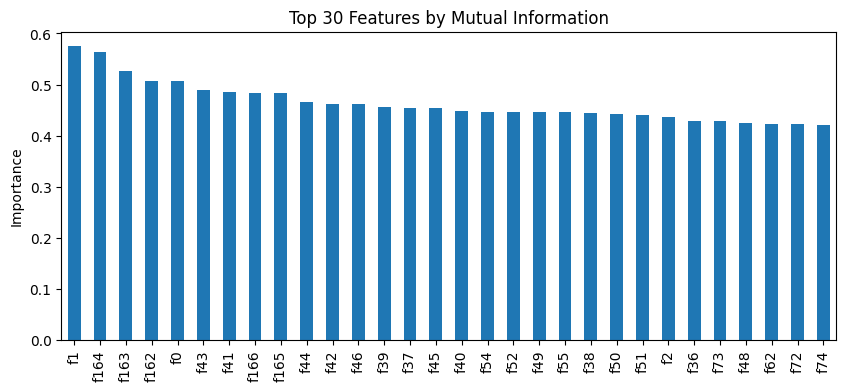

In [ ]:
import matplotlib.pyplot as plt
mi_series.head(30).plot(kind='bar', figsize=(10,4))
plt.title("Top 30 Features by Mutual Information")
plt.ylabel("Importance")
plt.show()

**1. Random Forest**

1) with esc50_features_raw.csv

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# ====== Paths / Config ======
META_CSV = 'ESC-50_data/meta/esc50.csv'         # Contains 'filename' and 'fold'
FEAT_CSV = 'data_out/esc50_features_raw.csv'    # Your precomputed features
OUT_DIR  = 'data_out'
PLOT_DIR = os.path.join(OUT_DIR, 'plots_raw')
os.makedirs(PLOT_DIR, exist_ok=True)

RUN_DEEP_LEARNING = False   # Toggle True to also run a simple MLP and plot its curves

# ====== Load data ======
meta = pd.read_csv(META_CSV)    # expected columns: filename, category, target, fold, ...
feat = pd.read_csv(FEAT_CSV)    # expected columns: filename, target, label(category), f0..fN (maybe fold)

# ====== Attach 'fold' only if missing in feature CSV ======
if 'fold' not in feat.columns:
    df = feat.merge(meta[['filename', 'fold']], on='filename', how='left')
    if df['fold'].isna().any():
        missing = df[df['fold'].isna()]['filename'].head(8).tolist()
        raise ValueError(
            f"Missing 'fold' for some files (e.g., {missing}). "
            "Ensure 'filename' matches between feature and meta CSV."
        )
else:
    df = feat.copy()

# ====== Determine label column robustly ======
# Try 'label' first (your pipeline wrote category into 'label'); fall back to 'category' or 'target'.
label_col = None
for cand in ['label', 'category', 'target']:
    if cand in df.columns:
        label_col = cand
        break
if label_col is None:
    raise ValueError("No label column found. Expected one of: 'label', 'category', 'target'.")

# ====== Select only true feature columns: f + digits (e.g., f0, f1, ...) ======
feature_cols = [c for c in df.columns if re.fullmatch(r'f\d+', c)]
feature_cols = sorted(feature_cols, key=lambda x: int(x[1:]))  # keep f0..fN order

# Safety check: ensure we didn't accidentally include non-feature columns
accidentally = [c for c in df.columns if c.startswith('f') and c not in feature_cols]
if len(accidentally) > 0:
    print(f"[INFO] Excluding non-feature 'f*' columns from features: {accidentally}")

# ====== Build X / y / groups ======
# Convert features to numeric safely; fill remaining NaNs with 0.0
feat_df = df[feature_cols].apply(pd.to_numeric, errors='coerce')
n_nans = int(feat_df.isna().sum().sum())
if n_nans > 0:
    print(f"[WARN] Found {n_nans} NaNs in features -> filling with 0.0")
    feat_df = feat_df.fillna(0.0)

X_all   = feat_df.to_numpy(dtype=float)
y_label = df[label_col].astype(str).to_numpy()
groups  = df['fold'].to_numpy()

print(f"[OK] Feature matrix: {X_all.shape}, label column: '{label_col}', folds present: {np.unique(groups)}")

# ====== Encode labels ======
le = LabelEncoder()
y_enc = le.fit_transform(y_label)
num_classes = len(le.classes_)
print(f"[OK] Encoded {num_classes} classes.")

# ====== Split by ESC-50 folds ======
folds = groups.astype(int)
train_mask = np.isin(folds, [1, 2, 3])  # Train: folds 1-3
val_mask   = (folds == 4)               # Val:   fold 4
test_mask  = (folds == 5)               # Test:  fold 5

X_train, y_train = X_all[train_mask], y_enc[train_mask]
X_val,   y_val   = X_all[val_mask],   y_enc[val_mask]
X_test0, y_test0 = X_all[test_mask],  y_enc[test_mask]

print("Split by Fold →",
      "Train:", X_train.shape, " Val:", X_val.shape, " Test(all):", X_test0.shape)

# ====== Make a small Inference subset from Test (optional) ======
inference_ratio = 0.2
if len(X_test0) > 0:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=inference_ratio, random_state=42)
    keep_idx, inf_idx = next(sss.split(X_test0, y_test0))
    X_test,  y_test  = X_test0[keep_idx], y_test0[keep_idx]
    X_infer, y_infer = X_test0[inf_idx],  y_test0[inf_idx]
else:
    # Edge case: if no fold==5 present
    X_test, y_test = X_val.copy(), y_val.copy()
    X_infer, y_infer = np.empty((0, X_val.shape[1])), np.empty((0,), dtype=int)

print("Final Split →",
      "Train:", X_train.shape,
      " Val:",  X_val.shape,
      " Test:", X_test.shape,
      " Inference:", X_infer.shape)

# ====== Feature scaling (helps stability and comparability) ======
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)
X_inf_s   = scaler.transform(X_infer) if len(X_infer) else X_infer

# ====== Train RandomForest ======
clf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
    oob_score=True,     # enables OOB score for a pseudo training curve
    bootstrap=True
)
clf.fit(X_train_s, y_train)

# ====== Evaluate ======
val_pred  = clf.predict(X_val_s)
test_pred = clf.predict(X_test_s)

val_acc = accuracy_score(y_val, val_pred)
val_f1  = f1_score(y_val,  val_pred, average="macro")
val_p   = precision_score(y_val, val_pred, average="macro", zero_division=0)
val_r   = recall_score(y_val,    val_pred, average="macro", zero_division=0)

test_acc = accuracy_score(y_test, test_pred)
test_f1  = f1_score(y_test,  test_pred, average="macro")
test_p   = precision_score(y_test, test_pred, average="macro", zero_division=0)
test_r   = recall_score(y_test,    test_pred, average="macro", zero_division=0)

print(f"[RF] Validation  ACC: {val_acc:.3f}  Macro-F1: {val_f1:.3f}")
print(f"[RF] Test        ACC: {test_acc:.3f}  Macro-F1: {test_f1:.3f}\n")

print("[Validation REPORT]\n", classification_report(y_val,  val_pred,  target_names=le.classes_))
print("[Testing  REPORT]\n", classification_report(y_test, test_pred, target_names=le.classes_))

# ====== Plot helpers ======
def plot_confmat(y_true, y_pred, classes, title, save_path):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(include_values=True, cmap=None, ax=ax, xticks_rotation=90, colorbar=False)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(save_path, dpi=200)
    plt.close(fig)

def plot_metric_bars(title, metrics_dict, save_path):
    keys = list(metrics_dict.keys())
    vals = [metrics_dict[k] for k in keys]
    fig = plt.figure()
    plt.bar(keys, vals)
    plt.ylim(0, 1.0)
    plt.ylabel("Score")
    plt.title(title)
    for i, v in enumerate(vals):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    fig.tight_layout()
    fig.savefig(save_path, dpi=200)
    plt.close(fig)

# ====== (1) Confusion matrices ======
plot_confmat(y_val,  val_pred,  le.classes_, "[RF] Confusion Matrix (Val)",  os.path.join(PLOT_DIR, "rf_confmat_val.png"))
plot_confmat(y_test, test_pred, le.classes_, "[RF] Confusion Matrix (Test)", os.path.join(PLOT_DIR, "rf_confmat_test.png"))

# ====== (2) Learning curves (train size vs CV) ======
train_sizes, train_scores, val_scores = learning_curve(
    estimator=RandomForestClassifier(
        n_estimators=300, max_features="sqrt", class_weight="balanced", n_jobs=-1, random_state=42
    ),
    X=X_train_s, y=y_train,
    cv=3, scoring="accuracy",
    train_sizes=np.linspace(0.2, 1.0, 5),
    shuffle=True, random_state=42, n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

fig = plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Train')
plt.plot(train_sizes, val_mean,   marker='o', label='CV')
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("[RF] Learning Curve (Accuracy vs Training Size)")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
fig.tight_layout()
fig.savefig(os.path.join(PLOT_DIR, "rf_learning_curve.png"), dpi=200)
plt.close(fig)

# ====== (3) OOB score vs n_estimators (pseudo 'training curve') ======
def plot_oob_curve(X, y, start=50, stop=800, step=50):
    oob_scores, ns = [], []
    rf = RandomForestClassifier(
        n_estimators=0, max_features="sqrt", class_weight="balanced",
        n_jobs=-1, random_state=42, oob_score=True, bootstrap=True, warm_start=True
    )
    for n in range(start, stop + 1, step):
        rf.set_params(n_estimators=n)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
        ns.append(n)
    fig = plt.figure()
    plt.plot(ns, oob_scores, marker='o')
    plt.xlabel("n_estimators")
    plt.ylabel("OOB Accuracy")
    plt.title("[RF] OOB Score vs n_estimators")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()
    fig.savefig(os.path.join(PLOT_DIR, "rf_oob_curve.png"), dpi=200)
    plt.close(fig)

plot_oob_curve(X_train_s, y_train)

# ====== (4) Evaluation metric bar charts ======
plot_metric_bars(
    "[RF] Validation Metrics",
    {"ACC": val_acc, "Precision": val_p, "Recall": val_r, "F1": val_f1},
    os.path.join(PLOT_DIR, "rf_val_metrics.png")
)
plot_metric_bars(
    "[RF] Test Metrics",
    {"ACC": test_acc, "Precision": test_p, "Recall": test_r, "F1": test_f1},
    os.path.join(PLOT_DIR, "rf_test_metrics.png")
)

# ====== (5) Feature importances (Top-25) ======
importances = clf.feature_importances_
idx_sorted = np.argsort(importances)[::-1][:25]
top_feats = [feature_cols[i] for i in idx_sorted]
top_vals  = importances[idx_sorted]

fig = plt.figure(figsize=(8, 10))
plt.barh(range(len(top_vals)), top_vals)
plt.yticks(range(len(top_feats)), top_feats)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("[RF] Top-25 Feature Importances")
fig.tight_layout()
fig.savefig(os.path.join(PLOT_DIR, "rf_feature_importances_top25.png"), dpi=200)
plt.close(fig)

# ====== (Optional) Simple MLP for 'deep learning' training curves ======
if RUN_DEEP_LEARNING:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    input_dim = X_train_s.shape[1]
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    ckpt_path = os.path.join(OUT_DIR, "mlp_best.keras")
    cbs = [
        keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
    ]

    hist = model.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=50, batch_size=64, verbose=2, callbacks=cbs
    )

    # Accuracy curves
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(hist.history['val_accuracy'], marker='o', label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("[MLP] Training Curve (Accuracy)")
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()
    fig.savefig(os.path.join(PLOT_DIR, "mlp_training_curve_accuracy.png"), dpi=200)
    plt.close(fig)

    # Loss curves
    fig = plt.figure()
    plt.plot(hist.history['loss'], marker='o', label='Train Loss')
    plt.plot(hist.history['val_loss'], marker='o', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("[MLP] Training Curve (Loss)")
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()
    fig.savefig(os.path.join(PLOT_DIR, "mlp_training_curve_loss.png"), dpi=200)
    plt.close(fig)

    mlp_val = model.evaluate(X_val_s,  y_val,  verbose=0)
    mlp_tst = model.evaluate(X_test_s, y_test, verbose=0)
    print(f"[MLP] Validation  ACC: {mlp_val[1]:.3f}")
    print(f"[MLP] Test        ACC: {mlp_tst[1]:.3f}")

print(f"Done. All plots saved under: {PLOT_DIR}")


[INFO] Excluding non-feature 'f*' columns from features: ['filename', 'fold']
[OK] Feature matrix: (2000, 173), label column: 'label', folds present: [1 2 3 4 5]
[OK] Encoded 50 classes.
Split by Fold → Train: (1200, 173)  Val: (400, 173)  Test(all): (400, 173)
Final Split → Train: (1200, 173)  Val: (400, 173)  Test: (320, 173)  Inference: (80, 173)
[RF] Validation  ACC: 0.545  Macro-F1: 0.512
[RF] Test        ACC: 0.428  Macro-F1: 0.407

[Validation REPORT]
                   precision    recall  f1-score   support

        airplane       0.60      0.38      0.46         8
       breathing       0.40      0.50      0.44         8
  brushing_teeth       0.86      0.75      0.80         8
     can_opening       0.64      0.88      0.74         8
        car_horn       1.00      0.25      0.40         8
             cat       0.29      0.25      0.27         8
        chainsaw       0.64      0.88      0.74         8
  chirping_birds       0.78      0.88      0.82         8
    church_be

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Done. All plots saved under: data_out/plots_raw


2) with esc50_feautes_normalized.csv

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder  # StandardScaler not used here
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# ====== Paths / Config ======
META_CSV = 'ESC-50_data/meta/esc50.csv'                     # has: filename, fold, ...
NORM_FEAT_CSV = 'data_out/esc50_features_normalized_corrected.csv'  # normalized features (no filename/fold)
RAW_FEAT_CSV  = 'data_out/esc50_features_raw.csv'           # to recover filename order
OUT_DIR  = 'data_out'
PLOT_DIR = os.path.join(OUT_DIR, 'plots_normal')
os.makedirs(PLOT_DIR, exist_ok=True)

RUN_DEEP_LEARNING = False  # unchanged

# ====== Load normalized features (no filename/fold) ======
norm = pd.read_csv(NORM_FEAT_CSV)   # columns: f0..fN, target, label
meta = pd.read_csv(META_CSV)        # columns include: filename, fold, ...
raw  = pd.read_csv(RAW_FEAT_CSV, usecols=['filename'])  # only to recover filename per row

# ====== Sanity check row alignment ======
if len(norm) != len(raw):
    raise ValueError("Row count mismatch between normalized and raw features. "
                     "Cannot safely re-attach filename/fold.")

# ====== Re-attach filename, then merge fold from meta ======
norm = norm.copy()
norm['filename'] = raw['filename']  # assume identical order as produced from the same pipeline
df = norm.merge(meta[['filename', 'fold']], on='filename', how='left')

if df['fold'].isna().any():
    missing = df[df['fold'].isna()]['filename'].head(8).tolist()
    raise ValueError(
        f"Missing 'fold' for some files (e.g., {missing}). "
        "Ensure META_CSV and RAW_FEAT_CSV filenames match."
    )

# ====== Determine label column ======
label_col = 'label' if 'label' in df.columns else ('category' if 'category' in df.columns else 'target')
if label_col not in df.columns:
    raise ValueError("No label column found. Expected one of: 'label', 'category', 'target'.")

# ====== Select only true feature columns: f + digits (e.g., f0, f1, ...) ======
feature_cols = [c for c in df.columns if re.fullmatch(r'f\d+', c)]
feature_cols = sorted(feature_cols, key=lambda x: int(x[1:]))

# ====== Build X / y / groups ======
# Values are already standardized -> no second scaling
X_all   = df[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0).to_numpy(dtype=float)
y_label = df[label_col].astype(str).to_numpy()
groups  = df['fold'].to_numpy()

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y_label)
num_classes = len(le.classes_)

print(f"[OK] X_all: {X_all.shape}, classes: {num_classes}, folds: {np.unique(groups)}")

# ====== Split by ESC-50 folds ======
folds = groups.astype(int)
train_mask = np.isin(folds, [1, 2, 3])  # Train: 1–3
val_mask   = (folds == 4)               # Val: 4
test_mask  = (folds == 5)               # Test: 5

X_train, y_train = X_all[train_mask], y_enc[train_mask]
X_val,   y_val   = X_all[val_mask],   y_enc[val_mask]
X_test0, y_test0 = X_all[test_mask],  y_enc[test_mask]

print("Split by Fold →",
      "Train:", X_train.shape, " Val:", X_val.shape, " Test(all):", X_test0.shape)

# ====== Optional inference subset from Test ======
inference_ratio = 0.2
if len(X_test0) > 0:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=inference_ratio, random_state=42)
    keep_idx, inf_idx = next(sss.split(X_test0, y_test0))
    X_test,  y_test  = X_test0[keep_idx], y_test0[keep_idx]
    X_infer, y_infer = X_test0[inf_idx],  y_test0[inf_idx]
else:
    X_test, y_test = X_val.copy(), y_val.copy()
    X_infer, y_infer = np.empty((0, X_val.shape[1])), np.empty((0,), dtype=int)

print("Final Split →",
      "Train:", X_train.shape, " Val:", X_val.shape,
      " Test:", X_test.shape, " Inference:", X_infer.shape)

# ====== Train RandomForest (no extra scaling) ======
clf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    bootstrap=True
)
clf.fit(X_train, y_train)

# ====== Evaluate ======
val_pred  = clf.predict(X_val)
test_pred = clf.predict(X_test)

val_acc = accuracy_score(y_val, val_pred)
val_f1  = f1_score(y_val,  val_pred, average="macro")
val_p   = precision_score(y_val, val_pred, average="macro", zero_division=0)
val_r   = recall_score(y_val,    val_pred, average="macro", zero_division=0)

test_acc = accuracy_score(y_test, test_pred)
test_f1  = f1_score(y_test,  test_pred, average="macro")
test_p   = precision_score(y_test, test_pred, average="macro", zero_division=0)
test_r   = recall_score(y_test,    test_pred, average="macro", zero_division=0)

print(f"[RF] Validation  ACC: {val_acc:.3f}  Macro-F1: {val_f1:.3f}")
print(f"[RF] Test        ACC: {test_acc:.3f}  Macro-F1: {test_f1:.3f}\n")

print("[Validation REPORT]\n", classification_report(y_val,  val_pred,  target_names=le.classes_))
print("[Testing  REPORT]\n", classification_report(y_test, test_pred, target_names=le.classes_))

# ====== Plot helpers ======
def plot_confmat(y_true, y_pred, classes, title, save_path):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(include_values=True, cmap=None, ax=ax, xticks_rotation=90, colorbar=False)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(save_path, dpi=200)
    plt.close(fig)

def plot_metric_bars(title, metrics_dict, save_path):
    keys = list(metrics_dict.keys())
    vals = [metrics_dict[k] for k in keys]
    fig = plt.figure()
    plt.bar(keys, vals)
    plt.ylim(0, 1.0)
    plt.ylabel("Score")
    plt.title(title)
    for i, v in enumerate(vals):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    fig.tight_layout()
    fig.savefig(save_path, dpi=200)
    plt.close(fig)

# ====== (1) Confusion matrices ======
plot_confmat(y_val,  val_pred,  le.classes_, "[RF] Confusion Matrix (Val)",  os.path.join(PLOT_DIR, "rf_confmat_val.png"))
plot_confmat(y_test, test_pred, le.classes_, "[RF] Confusion Matrix (Test)", os.path.join(PLOT_DIR, "rf_confmat_test.png"))

# ====== (2) Learning curves (train size vs CV) ======
train_sizes, train_scores, val_scores = learning_curve(
    estimator=RandomForestClassifier(
        n_estimators=300, max_features="sqrt", class_weight="balanced", n_jobs=-1, random_state=42
    ),
    X=X_train, y=y_train,
    cv=3, scoring="accuracy",
    train_sizes=np.linspace(0.2, 1.0, 5),
    shuffle=True, random_state=42, n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

fig = plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Train')
plt.plot(train_sizes, val_mean,   marker='o', label='CV')
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("[RF] Learning Curve (Accuracy vs Training Size)")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
fig.tight_layout()
fig.savefig(os.path.join(PLOT_DIR, "rf_learning_curve.png"), dpi=200)
plt.close(fig)

# ====== (3) OOB score vs n_estimators ======
def plot_oob_curve(X, y, start=50, stop=800, step=50):
    oob_scores, ns = [], []
    rf = RandomForestClassifier(
        n_estimators=0, max_features="sqrt", class_weight="balanced",
        n_jobs=-1, random_state=42, oob_score=True, bootstrap=True, warm_start=True
    )
    for n in range(start, stop + 1, step):
        rf.set_params(n_estimators=n)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
        ns.append(n)
    fig = plt.figure()
    plt.plot(ns, oob_scores, marker='o')
    plt.xlabel("n_estimators")
    plt.ylabel("OOB Accuracy")
    plt.title("[RF] OOB Score vs n_estimators")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout()
    fig.savefig(os.path.join(PLOT_DIR, "rf_oob_curve.png"), dpi=200)
    plt.close(fig)

plot_oob_curve(X_train, y_train)

# ====== (4) Metric bar charts ======
plot_metric_bars(
    "[RF] Validation Metrics",
    {"ACC": val_acc, "Precision": val_p, "Recall": val_r, "F1": val_f1},
    os.path.join(PLOT_DIR, "rf_val_metrics.png")
)
plot_metric_bars(
    "[RF] Test Metrics",
    {"ACC": test_acc, "Precision": test_p, "Recall": test_r, "F1": test_f1},
    os.path.join(PLOT_DIR, "rf_test_metrics.png")
)

# ====== (5) Feature importances (Top-25) ======
importances = clf.feature_importances_
idx_sorted = np.argsort(importances)[::-1][:25]
top_feats = [feature_cols[i] for i in idx_sorted]
top_vals  = importances[idx_sorted]

fig = plt.figure(figsize=(8, 10))
plt.barh(range(len(top_vals)), top_vals)
plt.yticks(range(len(top_feats)), top_feats)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("[RF] Top-25 Feature Importances")
fig.tight_layout()
fig.savefig(os.path.join(PLOT_DIR, "rf_feature_importances_top25.png"), dpi=200)
plt.close(fig)

print(f"Done. All plots saved under: {PLOT_DIR}")


[OK] X_all: (2000, 173), classes: 50, folds: [1 2 3 4 5]
Split by Fold → Train: (1200, 173)  Val: (400, 173)  Test(all): (400, 173)
Final Split → Train: (1200, 173)  Val: (400, 173)  Test: (320, 173)  Inference: (80, 173)
[RF] Validation  ACC: 0.535  Macro-F1: 0.498
[RF] Test        ACC: 0.425  Macro-F1: 0.402

[Validation REPORT]
                   precision    recall  f1-score   support

        airplane       0.60      0.38      0.46         8
       breathing       0.45      0.62      0.53         8
  brushing_teeth       0.86      0.75      0.80         8
     can_opening       0.58      0.88      0.70         8
        car_horn       1.00      0.25      0.40         8
             cat       0.17      0.12      0.14         8
        chainsaw       0.70      0.88      0.78         8
  chirping_birds       0.78      0.88      0.82         8
    church_bells       0.40      0.75      0.52         8
        clapping       0.73      1.00      0.84         8
     clock_alarm       0.88

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Done. All plots saved under: data_out/plots_normal


**2. Random Forest with Transfer Learning with esc50_raw.csv**

In [ ]:
!pip install librosa==0.10.1 resampy==0.4.3 soundfile==0.12.1

In [ ]:
import os
import re
import pathlib
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import soundfile as sf

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# ========= Paths / Config =========
META_CSV   = 'ESC-50_data/meta/esc50.csv'     # contains 'filename', 'fold', 'category', 'target'
RAW_FEAT   = 'data_out/esc50_features_raw.csv' # used to read filename/label only
AUDIO_DIR  = 'ESC-50_data/audio'              # original ESC-50 wav files
OUT_DIR    = 'data_out'
PLOT_DIR   = os.path.join(OUT_DIR, 'plots_yamnet_rf')
EMB_CACHE  = pathlib.Path(os.path.join(OUT_DIR, 'yamnet_cache'))
os.makedirs(PLOT_DIR, exist_ok=True); EMB_CACHE.mkdir(exist_ok=True)

RUN_MLP = True          # also train a small MLP on embeddings and plot its curves
TOPK_IMPORTANCE = 30    # number of top features to visualize for RF

# ========= Load tables and recover folds =========
meta = pd.read_csv(META_CSV)                              # expects filename, fold, ...
raw  = pd.read_csv(RAW_FEAT, usecols=['filename','label','target'])

# Merge meta to attach 'fold' (required for ESC-50 standard split)
df = raw.merge(meta[['filename','fold']], on='filename', how='left')
if df['fold'].isna().any():
    missing = df[df['fold'].isna()]['filename'].head(8).tolist()
    raise ValueError(f"Missing fold for: {missing} — check META_CSV vs RAW_FEAT filename alignment.")

# ========= YAMNet model =========
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")

def load_audio_16k_mono(path, target_sr=16000):
    y, sr = sf.read(path, dtype='float32', always_2d=False)
    if y.ndim > 1:
        y = np.mean(y, axis=1)          # mono
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_fast")
    y = np.clip(y, -1.0, 1.0).astype(np.float32)  # YAMNet expects [-1,1] float32
    return y

@tf.function
def yamnet_forward(waveform_1d):
    # Inputs: 1-D float32 waveform
    scores, embeddings, spectrogram = yamnet(waveform_1d)
    return embeddings  # [frames, 1024]

def yamnet_embedding(path):
    y = load_audio_16k_mono(path, 16000)
    wf = tf.convert_to_tensor(y, dtype=tf.float32)
    embs = yamnet_forward(wf).numpy()        # shape: (T, 1024)
    # Time pooling: mean + std -> (2048,)
    return np.hstack([embs.mean(axis=0), embs.std(axis=0)])

# ========= Build embedding matrix with caching =========
X_yam, y_label, groups = [], [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = os.path.join(AUDIO_DIR, row['filename'])
    npy_path = EMB_CACHE / (row['filename'].replace('.wav', '.npy'))

    if npy_path.exists():
        feat = np.load(npy_path)
    else:
        feat = yamnet_embedding(wav_path)
        np.save(npy_path, feat)

    X_yam.append(feat)
    y_label.append(row['label'])
    groups.append(row['fold'])

X_yam = np.vstack(X_yam)
y_label = np.array(y_label)
groups = np.array(groups)
print("YAMNet feature shape:", X_yam.shape)  # (N, 2048)

# ========= Encode labels =========
le = LabelEncoder()
y_enc = le.fit_transform(y_label)
num_classes = len(le.classes_)
print(f"Classes: {num_classes}")

# ========= Split by ESC-50 folds =========
folds = groups.astype(int)
train_mask = np.isin(folds, [1,2,3])  # Train: folds 1–3
val_mask   = (folds == 4)             # Val:   fold 4
test_mask  = (folds == 5)             # Test:  fold 5

X_train, y_train = X_yam[train_mask], y_enc[train_mask]
X_val,   y_val   = X_yam[val_mask],   y_enc[val_mask]
X_test0, y_test0 = X_yam[test_mask],  y_enc[test_mask]
print("Split → Train:", X_train.shape, " Val:", X_val.shape, " Test(all):", X_test0.shape)

# ========= Optional inference subset from Test =========
inference_ratio = 0.2
if len(X_test0) > 0:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=inference_ratio, random_state=42)
    keep_idx, inf_idx = next(sss.split(X_test0, y_test0))
    X_test,  y_test  = X_test0[keep_idx], y_test0[keep_idx]
    X_infer, y_infer = X_test0[inf_idx],  y_test0[inf_idx]
else:
    X_test, y_test = X_val.copy(), y_val.copy()
    X_infer, y_infer = np.empty((0, X_val.shape[1])), np.empty((0,), dtype=int)

print("Final Split → Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape, " Inference:", X_infer.shape)

# ========= Scaling (helps RF/MLP stability) =========
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)
X_infer_s = scaler.transform(X_infer) if len(X_infer) else X_infer

# ========= Train RandomForest on embeddings =========
clf = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    bootstrap=True
)
clf.fit(X_train_s, y_train)

# ========= Evaluate RF =========
def eval_and_print(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    p   = precision_score(y_true, y_pred, average="macro", zero_division=0)
    r   = recall_score(y_true, y_pred, average="macro", zero_division=0)
    print(f"[{name}] ACC: {acc:.3f}  Macro-F1: {f1:.3f}  P: {p:.3f}  R: {r:.3f}")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    return {"ACC": acc, "Precision": p, "Recall": r, "F1": f1}

val_pred  = clf.predict(X_val_s)
test_pred = clf.predict(X_test_s)
val_metrics  = eval_and_print("YAMNet+RF (Val)",  y_val,  val_pred)
test_metrics = eval_and_print("YAMNet+RF (Test)", y_test, test_pred)

# ========= Plot helpers =========
def plot_confmat(y_true, y_pred, classes, title, save_path):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(include_values=True, cmap=None, ax=ax, xticks_rotation=90, colorbar=False)
    ax.set_title(title)
    fig.tight_layout(); fig.savefig(save_path, dpi=200); plt.close(fig)

def plot_metric_bars(title, metrics_dict, save_path):
    keys = list(metrics_dict.keys()); vals = [metrics_dict[k] for k in keys]
    fig = plt.figure(); plt.bar(keys, vals); plt.ylim(0,1.0); plt.ylabel("Score"); plt.title(title)
    for i, v in enumerate(vals):
        plt.text(i, v+0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    fig.tight_layout(); fig.savefig(save_path, dpi=200); plt.close(fig)

# Confusion Matrices (RF)
plot_confmat(y_val,  val_pred,  le.classes_, "[YAMNet+RF] Confusion (Val)",  os.path.join(PLOT_DIR, "rf_confmat_val.png"))
plot_confmat(y_test, test_pred, le.classes_, "[YAMNet+RF] Confusion (Test)", os.path.join(PLOT_DIR, "rf_confmat_test.png"))

# Metric Bars (RF)
plot_metric_bars("[YAMNet+RF] Validation Metrics", val_metrics,  os.path.join(PLOT_DIR, "rf_val_metrics.png"))
plot_metric_bars("[YAMNet+RF] Test Metrics",       test_metrics, os.path.join(PLOT_DIR, "rf_test_metrics.png"))

# Learning Curve (RF)
train_sizes, train_scores, val_scores = learning_curve(
    estimator=RandomForestClassifier(
        n_estimators=400, max_features="sqrt", class_weight="balanced", n_jobs=-1, random_state=42
    ),
    X=X_train_s, y=y_train, cv=3, scoring="accuracy",
    train_sizes=np.linspace(0.2, 1.0, 5), shuffle=True, random_state=42, n_jobs=-1
)
fig = plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1),   marker='o', label='CV')
plt.xlabel("Training Samples"); plt.ylabel("Accuracy"); plt.title("[RF] Learning Curve")
plt.legend(); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
fig.tight_layout(); fig.savefig(os.path.join(PLOT_DIR, "rf_learning_curve.png"), dpi=200); plt.close(fig)

# OOB curve (RF)
def plot_oob_curve(X, y, start=100, stop=1000, step=100):
    scores, ns = [], []
    rf = RandomForestClassifier(
        n_estimators=0, max_features="sqrt", class_weight="balanced",
        n_jobs=-1, random_state=42, oob_score=True, bootstrap=True, warm_start=True
    )
    for n in range(start, stop+1, step):
        rf.set_params(n_estimators=n); rf.fit(X, y); scores.append(rf.oob_score_); ns.append(n)
    fig = plt.figure(); plt.plot(ns, scores, marker='o')
    plt.xlabel("n_estimators"); plt.ylabel("OOB Accuracy"); plt.title("[RF] OOB vs n_estimators")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout(); fig.savefig(os.path.join(PLOT_DIR, "rf_oob_curve.png"), dpi=200); plt.close(fig)

plot_oob_curve(X_train_s, y_train)

# Feature Importances (RF on embeddings)
importances = clf.feature_importances_
idx_sorted = np.argsort(importances)[::-1][:TOPK_IMPORTANCE]
top_feats  = [f"emb_{i}" for i in idx_sorted]   # name them generically
top_vals   = importances[idx_sorted]
fig = plt.figure(figsize=(8, max(6, TOPK_IMPORTANCE*0.25)))
plt.barh(range(len(top_vals)), top_vals); plt.yticks(range(len(top_feats)), top_feats); plt.gca().invert_yaxis()
plt.xlabel("Importance"); plt.title(f"[RF] Top-{TOPK_IMPORTANCE} Feature Importances (YAMNet embeddings)")
fig.tight_layout(); fig.savefig(os.path.join(PLOT_DIR, "rf_feature_importances_topk.png"), dpi=200); plt.close(fig)

# ========= Optional MLP head (DL) on embeddings for training curves =========
if RUN_MLP:
    from tensorflow import keras
    from tensorflow.keras import layers

    input_dim = X_train_s.shape[1]
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    ckpt_path = os.path.join(OUT_DIR, "yamnet_mlp_best.keras")
    cbs = [
        keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
    ]

    hist = model.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=60, batch_size=64, verbose=2, callbacks=cbs
    )

    # Training curves (Accuracy / Loss)
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(hist.history['val_accuracy'], marker='o', label='Val Acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("[MLP] Training Curve (Accuracy)")
    plt.legend(); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout(); fig.savefig(os.path.join(PLOT_DIR, "mlp_training_curve_accuracy.png"), dpi=200); plt.close(fig)

    fig = plt.figure()
    plt.plot(hist.history['loss'], marker='o', label='Train Loss')
    plt.plot(hist.history['val_loss'], marker='o', label='Val Loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("[MLP] Training Curve (Loss)")
    plt.legend(); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout(); fig.savefig(os.path.join(PLOT_DIR, "mlp_training_curve_loss.png"), dpi=200); plt.close(fig)

    # Eval MLP on Val/Test and plot confusion matrices + metric bars
    mlp_val_pred  = np.argmax(model.predict(X_val_s,  verbose=0), axis=1)
    mlp_test_pred = np.argmax(model.predict(X_test_s, verbose=0), axis=1)
    mlp_val_metrics  = eval_and_print("YAMNet+MLP (Val)",  y_val,  mlp_val_pred)
    mlp_test_metrics = eval_and_print("YAMNet+MLP (Test)", y_test, mlp_test_pred)

    plot_confmat(y_val,  mlp_val_pred,  le.classes_, "[YAMNet+MLP] Confusion (Val)",  os.path.join(PLOT_DIR, "mlp_confmat_val.png"))
    plot_confmat(y_test, mlp_test_pred, le.classes_, "[YAMNet+MLP] Confusion (Test)", os.path.join(PLOT_DIR, "mlp_confmat_test.png"))

    plot_metric_bars("[YAMNet+MLP] Validation Metrics", mlp_val_metrics,  os.path.join(PLOT_DIR, "mlp_val_metrics.png"))
    plot_metric_bars("[YAMNet+MLP] Test Metrics",       mlp_test_metrics, os.path.join(PLOT_DIR, "mlp_test_metrics.png"))

print(f"All plots saved to: {PLOT_DIR}")


100%|██████████| 2000/2000 [00:00<00:00, 2354.89it/s]


YAMNet feature shape: (2000, 2048)
Classes: 50
Split → Train: (1200, 2048)  Val: (400, 2048)  Test(all): (400, 2048)
Final Split → Train: (1200, 2048)  Val: (400, 2048)  Test: (320, 2048)  Inference: (80, 2048)
[YAMNet+RF (Val)] ACC: 0.838  Macro-F1: 0.834  P: 0.847  R: 0.838
                  precision    recall  f1-score   support

        airplane       0.38      0.38      0.38         8
       breathing       0.67      0.75      0.71         8
  brushing_teeth       0.89      1.00      0.94         8
     can_opening       0.60      0.75      0.67         8
        car_horn       0.80      1.00      0.89         8
             cat       1.00      0.75      0.86         8
        chainsaw       0.89      1.00      0.94         8
  chirping_birds       0.88      0.88      0.88         8
    church_bells       1.00      1.00      1.00         8
        clapping       1.00      1.00      1.00         8
     clock_alarm       0.80      1.00      0.89         8
      clock_tick       0.3

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the 

Epoch 1/60

Epoch 1: val_accuracy improved from -inf to 0.55250, saving model to data_out/yamnet_mlp_best.keras
19/19 - 2s - 110ms/step - accuracy: 0.1842 - loss: 4.1885 - val_accuracy: 0.5525 - val_loss: 1.9398
Epoch 2/60

Epoch 2: val_accuracy improved from 0.55250 to 0.63750, saving model to data_out/yamnet_mlp_best.keras
19/19 - 1s - 43ms/step - accuracy: 0.4725 - loss: 2.3853 - val_accuracy: 0.6375 - val_loss: 1.4058
Epoch 3/60

Epoch 3: val_accuracy improved from 0.63750 to 0.71250, saving model to data_out/yamnet_mlp_best.keras
19/19 - 1s - 48ms/step - accuracy: 0.5717 - loss: 1.6829 - val_accuracy: 0.7125 - val_loss: 1.1502
Epoch 4/60

Epoch 4: val_accuracy improved from 0.71250 to 0.72500, saving model to data_out/yamnet_mlp_best.keras
19/19 - 1s - 64ms/step - accuracy: 0.6500 - loss: 1.3694 - val_accuracy: 0.7250 - val_loss: 1.0517
Epoch 5/60

Epoch 5: val_accuracy did not improve from 0.72500
19/19 - 0s - 26ms/step - accuracy: 0.6750 - loss: 1.2224 - val_accuracy: 0.7225 - v

**Add Self Supervised Learning**

In [ ]:

"""
YAMNet Transfer Learning → RandomForest (baseline) → Self-Training (Pseudo-Labeling)
Saves: confusion matrices, learning curves (RF/MLP), metric bar charts, RF feature importances
"""

import os
import re
import json
import pathlib
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import soundfile as sf

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# ========= Paths / Config =========
META_CSV   = 'ESC-50_data/meta/esc50.csv'       # has: filename, fold, category, target
RAW_FEAT   = 'data_out/esc50_features_raw.csv'  # to read filename/label only
AUDIO_DIR  = 'ESC-50_data/audio'                # original ESC-50 wav files
OUT_DIR    = 'data_out'
PLOT_DIR   = os.path.join(OUT_DIR, 'plots_yamnet_rf_tmp')
SSL_DIR    = os.path.join(OUT_DIR, 'ssl_results')
EMB_CACHE  = Path(os.path.join(OUT_DIR, 'yamnet_cache'))
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(SSL_DIR, exist_ok=True)
EMB_CACHE.mkdir(exist_ok=True)

RUN_MLP = True            # also train a simple MLP for DL curves/metrics
TOPK_IMPORTANCE = 30      # for RF feature importance plots
TH_LIST = [0.99, 0.95, 0.90, 0.85]  # pseudo-label thresholds to sweep

# ========= Utilities =========
def plot_confmat(y_true, y_pred, classes, title, save_path):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(include_values=True, cmap=None, ax=ax, xticks_rotation=90, colorbar=False)
    ax.set_title(title)
    fig.tight_layout(); fig.savefig(save_path, dpi=200); plt.close(fig)

def plot_metric_bars(title, metrics_dict, save_path):
    keys = list(metrics_dict.keys()); vals = [metrics_dict[k] for k in keys]
    fig = plt.figure(); plt.bar(keys, vals); plt.ylim(0,1.0); plt.ylabel("Score"); plt.title(title)
    for i, v in enumerate(vals):
        plt.text(i, v+0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
    fig.tight_layout(); fig.savefig(save_path, dpi=200); plt.close(fig)

def rf_learning_curve(X, y, title, save_path):
    ts, tr_sc, va_sc = learning_curve(
        estimator=RandomForestClassifier(
            n_estimators=400, max_features="sqrt", class_weight="balanced",
            n_jobs=-1, random_state=42
        ),
        X=X, y=y, cv=3, scoring="accuracy",
        train_sizes=np.linspace(0.2, 1.0, 5), shuffle=True, random_state=42, n_jobs=-1
    )
    fig = plt.figure()
    plt.plot(ts, tr_sc.mean(axis=1), marker='o', label='Train')
    plt.plot(ts, va_sc.mean(axis=1), marker='o', label='CV')
    plt.xlabel("Training Samples"); plt.ylabel("Accuracy"); plt.title(title)
    plt.legend(); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout(); fig.savefig(save_path, dpi=200); plt.close(fig)

def rf_oob_curve(X, y, title, save_path, start=100, stop=1000, step=100):
    scores, ns = [], []
    rf = RandomForestClassifier(
        n_estimators=0, max_features="sqrt", class_weight="balanced",
        n_jobs=-1, random_state=42, oob_score=True, bootstrap=True, warm_start=True
    )
    for n in range(start, stop+1, step):
        rf.set_params(n_estimators=n); rf.fit(X, y); scores.append(rf.oob_score_); ns.append(n)
    fig = plt.figure(); plt.plot(ns, scores, marker='o')
    plt.xlabel("n_estimators"); plt.ylabel("OOB Accuracy"); plt.title(title)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout(); fig.savefig(save_path, dpi=200); plt.close(fig)

def rf_feature_importance(clf, title, save_path, topk=30, prefix="emb_"):
    importances = clf.feature_importances_
    idx_sorted = np.argsort(importances)[::-1][:topk]
    feat_names = [f"{prefix}{i}" for i in idx_sorted]
    vals = importances[idx_sorted]
    fig = plt.figure(figsize=(8, max(6, topk*0.25)))
    plt.barh(range(len(vals)), vals)
    plt.yticks(range(len(feat_names)), feat_names)
    plt.gca().invert_yaxis()
    plt.xlabel("Importance"); plt.title(title)
    fig.tight_layout(); fig.savefig(save_path, dpi=200); plt.close(fig)

def metrics_dict(y_true, y_pred):
    return {
        "ACC": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1": f1_score(y_true, y_pred, average="macro"),
    }

def save_metrics_csv(path, metrics: dict):
    pd.DataFrame([metrics]).to_csv(path, index=False)

# ========= Load tables and recover folds =========
meta = pd.read_csv(META_CSV)                              # expects filename, fold, ...
raw  = pd.read_csv(RAW_FEAT, usecols=['filename','label','target'])
df = raw.merge(meta[['filename','fold']], on='filename', how='left')
if df['fold'].isna().any():
    missing = df[df['fold'].isna()]['filename'].head(8).tolist()
    raise ValueError(f"Missing fold for: {missing} — check META_CSV vs RAW_FEAT filename alignment.")

# ========= YAMNet model =========
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")

def load_audio_16k_mono(path, target_sr=16000):
    y, sr = sf.read(path, dtype='float32', always_2d=False)
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_fast")
    y = np.clip(y, -1.0, 1.0).astype(np.float32)
    return y

@tf.function
def yamnet_forward(waveform_1d):
    scores, embeddings, spectrogram = yamnet(waveform_1d)
    return embeddings  # [frames, 1024]

def yamnet_embedding(path):
    y = load_audio_16k_mono(path, 16000)
    wf = tf.convert_to_tensor(y, dtype=tf.float32)
    embs = yamnet_forward(wf).numpy()        # (T, 1024)
    return np.hstack([embs.mean(axis=0), embs.std(axis=0)])  # (2048,)

# ========= Build embedding matrix with caching =========
X_yam, y_label, groups = [], [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    wav_path = os.path.join(AUDIO_DIR, row['filename'])
    npy_path = EMB_CACHE / (row['filename'].replace('.wav', '.npy'))
    if npy_path.exists():
        feat = np.load(npy_path)
    else:
        feat = yamnet_embedding(wav_path)
        np.save(npy_path, feat)
    X_yam.append(feat); y_label.append(row['label']); groups.append(row['fold'])

X_yam = np.vstack(X_yam)
y_label = np.array(y_label)
groups = np.array(groups)
print("YAMNet feature shape:", X_yam.shape)  # (N, 2048)

# ========= Encode labels & split =========
le = LabelEncoder()
y_enc = le.fit_transform(y_label)
num_classes = len(le.classes_)
print(f"Classes: {num_classes}")

folds = groups.astype(int)
train_mask = np.isin(folds, [1,2,3])  # Train: 1–3
val_mask   = (folds == 4)             # Val:   4
test_mask  = (folds == 5)             # Test:  5

X_train, y_train = X_yam[train_mask], y_enc[train_mask]
X_val,   y_val   = X_yam[val_mask],   y_enc[val_mask]
X_test0, y_test0 = X_yam[test_mask],  y_enc[test_mask]
print("Split → Train:", X_train.shape, " Val:", X_val.shape, " Test(all):", X_test0.shape)

# Make inference subset from Test (for SSL)
inference_ratio = 0.2
if len(X_test0) > 0:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=inference_ratio, random_state=42)
    keep_idx, inf_idx = next(sss.split(X_test0, y_test0))
    X_test,  y_test  = X_test0[keep_idx], y_test0[keep_idx]
    X_infer, y_infer = X_test0[inf_idx],  y_test0[inf_idx]
else:
    X_test, y_test = X_val.copy(), y_val.copy()
    X_infer, y_infer = np.empty((0, X_val.shape[1])), np.empty((0,), dtype=int)
print("Final Split → Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape, " Inference:", X_infer.shape)

# ========= Scaling =========
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)
X_infer_s = scaler.transform(X_infer) if len(X_infer) else X_infer

# ========= Baseline: RandomForest on embeddings =========
clf = RandomForestClassifier(
    n_estimators=800, max_depth=None, max_features="sqrt",
    class_weight="balanced", n_jobs=-1, random_state=42,
    oob_score=True, bootstrap=True
)
clf.fit(X_train_s, y_train)

val_pred  = clf.predict(X_val_s)
test_pred = clf.predict(X_test_s)
val_metrics  = metrics_dict(y_val,  val_pred)
test_metrics = metrics_dict(y_test, test_pred)
print("[Baseline RF] Val:", val_metrics, "\n[Baseline RF] Test:", test_metrics)
print("[Validation REPORT]\n", classification_report(y_val,  val_pred,  target_names=le.classes_))
print("[Testing  REPORT]\n", classification_report(y_test, test_pred, target_names=le.classes_))

# Save baseline plots
plot_confmat(y_val,  val_pred,  le.classes_, "[Baseline RF] Confusion (Val)",
             os.path.join(PLOT_DIR, "rf_confmat_val.png"))
plot_confmat(y_test, test_pred, le.classes_, "[Baseline RF] Confusion (Test)",
             os.path.join(PLOT_DIR, "rf_confmat_test.png"))
plot_metric_bars("[Baseline RF] Validation Metrics", val_metrics,
                 os.path.join(PLOT_DIR, "rf_val_metrics.png"))
plot_metric_bars("[Baseline RF] Test Metrics", test_metrics,
                 os.path.join(PLOT_DIR, "rf_test_metrics.png"))
rf_learning_curve(X_train_s, y_train, "[Baseline RF] Learning Curve",
                  os.path.join(PLOT_DIR, "rf_learning_curve.png"))
rf_oob_curve(X_train_s, y_train, "[Baseline RF] OOB vs n_estimators",
             os.path.join(PLOT_DIR, "rf_oob_curve.png"))
rf_feature_importance(clf, f"[Baseline RF] Top-{TOPK_IMPORTANCE} Importances",
                      os.path.join(PLOT_DIR, f"rf_feature_importances_top{TOPK_IMPORTANCE}.png"),
                      topk=TOPK_IMPORTANCE, prefix="emb_")

# ========= Optional DL head (MLP) for training curves / metrics =========
if RUN_MLP:
    from tensorflow import keras
    from tensorflow.keras import layers

    input_dim = X_train_s.shape[1]
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    ckpt_path = os.path.join(OUT_DIR, "yamnet_mlp_best.keras")
    cbs = [
        keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
    ]
    hist = model.fit(
        X_train_s, y_train, validation_data=(X_val_s, y_val),
        epochs=60, batch_size=64, verbose=2, callbacks=cbs
    )
    # DL curves
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(hist.history['val_accuracy'], marker='o', label='Val Acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("[MLP] Training Curve (Accuracy)")
    plt.legend(); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout(); fig.savefig(os.path.join(PLOT_DIR, "mlp_training_curve_accuracy.png"), dpi=200); plt.close(fig)

    fig = plt.figure()
    plt.plot(hist.history['loss'], marker='o', label='Train Loss')
    plt.plot(hist.history['val_loss'], marker='o', label='Val Loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("[MLP] Training Curve (Loss)")
    plt.legend(); plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    fig.tight_layout(); fig.savefig(os.path.join(PLOT_DIR, "mlp_training_curve_loss.png"), dpi=200); plt.close(fig)

    # DL metrics + confusion/meterics plots
    mlp_val_pred  = np.argmax(model.predict(X_val_s,  verbose=0), axis=1)
    mlp_test_pred = np.argmax(model.predict(X_test_s, verbose=0), axis=1)
    mlp_val_metrics  = metrics_dict(y_val,  mlp_val_pred)
    mlp_test_metrics = metrics_dict(y_test, mlp_test_pred)
    plot_confmat(y_val,  mlp_val_pred,  le.classes_, "[MLP] Confusion (Val)",
                 os.path.join(PLOT_DIR, "mlp_confmat_val.png"))
    plot_confmat(y_test, mlp_test_pred, le.classes_, "[MLP] Confusion (Test)",
                 os.path.join(PLOT_DIR, "mlp_confmat_test.png"))
    plot_metric_bars("[MLP] Validation Metrics", mlp_val_metrics,
                     os.path.join(PLOT_DIR, "mlp_val_metrics.png"))
    plot_metric_bars("[MLP] Test Metrics", mlp_test_metrics,
                     os.path.join(PLOT_DIR, "mlp_test_metrics.png"))

# ========= Self-Training (Pseudo-Labeling) AFTER transfer learning =========
def self_training_rf(
    base_clf, X_tr_s, y_tr, X_val_s, y_val, X_te_s, y_te, X_inf_s,
    thresholds, save_dir, classes, topk=30
):
    """Run pseudo-label self-training with threshold sweep; save plots/metrics."""
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    # Save baseline again into SSL dir for side-by-side comparison
    base_val_pred = base_clf.predict(X_val_s)
    base_tst_pred = base_clf.predict(X_te_s)
    base_vm = metrics_dict(y_val, base_val_pred)
    base_tm = metrics_dict(y_te,  base_tst_pred)
    plot_confmat(y_val, base_val_pred, classes, "[Baseline RF] Confusion (Val)",
                 os.path.join(save_dir, "baseline_confmat_val.png"))
    plot_confmat(y_te,  base_tst_pred, classes, "[Baseline RF] Confusion (Test)",
                 os.path.join(save_dir, "baseline_confmat_test.png"))
    plot_metric_bars("[Baseline RF] Validation Metrics", base_vm,
                     os.path.join(save_dir, "baseline_val_metrics.png"))
    plot_metric_bars("[Baseline RF] Test Metrics", base_tm,
                     os.path.join(save_dir, "baseline_test_metrics.png"))
    rf_feature_importance(base_clf, f"[Baseline RF] Top-{topk} Importances",
                          os.path.join(save_dir, f"baseline_feature_importances_top{topk}.png"),
                          topk=topk, prefix="emb_")
    rf_learning_curve(X_tr_s, y_tr, "[Baseline RF] Learning Curve",
                      os.path.join(save_dir, "baseline_learning_curve.png"))
    rf_oob_curve(X_tr_s, y_tr, "[Baseline RF] OOB vs n_estimators",
                 os.path.join(save_dir, "baseline_oob_curve.png"))
    pd.DataFrame([base_vm]).to_csv(os.path.join(save_dir, "baseline_val_metrics.csv"), index=False)
    pd.DataFrame([base_tm]).to_csv(os.path.join(save_dir, "baseline_test_metrics.csv"), index=False)

    if X_inf_s is None or len(X_inf_s) == 0:
        print("[SSL] Inference set empty → skipping self-training.")
        return None

    proba = base_clf.predict_proba(X_inf_s)
    conf  = proba.max(axis=1)
    pseudo= proba.argmax(axis=1)

    summary = []
    best = {"val_acc": -1.0}

    for TH in thresholds:
        keep = conf >= TH
        n_sel = int(keep.sum())
        if n_sel == 0:
            summary.append({"TH": TH, "selected": 0})
            continue

        X_aug = np.vstack([X_tr_s, X_inf_s[keep]])
        y_aug = np.hstack([y_tr,   pseudo[keep]])

        clf_pl = RandomForestClassifier(
            n_estimators=900, max_depth=None, max_features="sqrt",
            class_weight="balanced", n_jobs=-1, random_state=42,
            oob_score=True, bootstrap=True
        )
        clf_pl.fit(X_aug, y_aug)

        v_pred = clf_pl.predict(X_val_s)
        t_pred = clf_pl.predict(X_te_s)
        vm = metrics_dict(y_val, v_pred)
        tm = metrics_dict(y_te,  t_pred)

        prefix = f"SelfTrain_RF_TH{int(TH*100)}"
        plot_confmat(y_val, v_pred, classes, f"[{prefix}] Confusion (Val)",
                     os.path.join(save_dir, f"{prefix}_confmat_val.png"))
        plot_confmat(y_te,  t_pred, classes, f"[{prefix}] Confusion (Test)",
                     os.path.join(save_dir, f"{prefix}_confmat_test.png"))
        plot_metric_bars(f"[{prefix}] Validation Metrics", vm,
                         os.path.join(save_dir, f"{prefix}_val_metrics.png"))
        plot_metric_bars(f"[{prefix}] Test Metrics", tm,
                         os.path.join(save_dir, f"{prefix}_test_metrics.png"))
        rf_feature_importance(clf_pl, f"[{prefix}] Top-{topk} Importances",
                              os.path.join(save_dir, f"{prefix}_feature_importances_top{topk}.png"),
                              topk=topk, prefix="emb_")
        rf_learning_curve(X_aug, y_aug, f"[{prefix}] Learning Curve",
                          os.path.join(save_dir, f"{prefix}_learning_curve.png"))
        rf_oob_curve(X_aug, y_aug, f"[{prefix}] OOB vs n_estimators",
                     os.path.join(save_dir, f"{prefix}_oob_curve.png"))

        rec = {"TH": TH, "selected": n_sel,
               **{f"val_{k}": vm[k] for k in vm},
               **{f"test_{k}": tm[k] for k in tm}}
        summary.append(rec)

        if vm["ACC"] > best["val_acc"]:
            best = {"val_acc": vm["ACC"], "TH": TH, "n_sel": n_sel,
                    "vm": vm, "tm": tm}

    pd.DataFrame(summary).to_csv(os.path.join(save_dir, "ssl_threshold_sweep.csv"), index=False)
    with open(os.path.join(save_dir, "best_ssl_result.json"), "w") as f:
        json.dump(best, f, indent=2)
    print(f"[SSL] Best TH={best['TH']:.2f} (selected={best['n_sel']}) | "
          f"Val ACC={best['vm']['ACC']:.3f}, Test ACC={best['tm']['ACC']:.3f}")
    return best

# ---- Run self-training on transfer-learned embeddings ----
best_ssl = self_training_rf(
    clf, X_train_s, y_train, X_val_s, y_val, X_test_s, y_test, X_infer_s,
    TH_LIST, SSL_DIR, le.classes_, topk=TOPK_IMPORTANCE
)

print(f"All baseline plots in: {PLOT_DIR}")
print(f"All SSL plots/metrics in: {SSL_DIR}")


100%|██████████| 2000/2000 [00:00<00:00, 2302.88it/s]


YAMNet feature shape: (2000, 2048)
Classes: 50
Split → Train: (1200, 2048)  Val: (400, 2048)  Test(all): (400, 2048)
Final Split → Train: (1200, 2048)  Val: (400, 2048)  Test: (320, 2048)  Inference: (80, 2048)
[Baseline RF] Val: {'ACC': 0.8375, 'Precision': 0.8471060606060605, 'Recall': 0.8375, 'F1': 0.8340812457236605} 
[Baseline RF] Test: {'ACC': 0.83125, 'Precision': 0.8577619047619046, 'Recall': 0.8309523809523809, 'F1': 0.8264078209372326}
[Validation REPORT]
                   precision    recall  f1-score   support

        airplane       0.38      0.38      0.38         8
       breathing       0.67      0.75      0.71         8
  brushing_teeth       0.89      1.00      0.94         8
     can_opening       0.60      0.75      0.67         8
        car_horn       0.80      1.00      0.89         8
             cat       1.00      0.75      0.86         8
        chainsaw       0.89      1.00      0.94         8
  chirping_birds       0.88      0.88      0.88         8
    ch

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the 

Epoch 1/60

Epoch 1: val_accuracy improved from -inf to 0.56500, saving model to data_out/yamnet_mlp_best.keras
19/19 - 3s - 144ms/step - accuracy: 0.1850 - loss: 4.3313 - val_accuracy: 0.5650 - val_loss: 1.9324
Epoch 2/60

Epoch 2: val_accuracy improved from 0.56500 to 0.63250, saving model to data_out/yamnet_mlp_best.keras
19/19 - 2s - 121ms/step - accuracy: 0.4500 - loss: 2.3463 - val_accuracy: 0.6325 - val_loss: 1.4022
Epoch 3/60

Epoch 3: val_accuracy improved from 0.63250 to 0.68250, saving model to data_out/yamnet_mlp_best.keras
19/19 - 3s - 146ms/step - accuracy: 0.5875 - loss: 1.6271 - val_accuracy: 0.6825 - val_loss: 1.1330
Epoch 4/60

Epoch 4: val_accuracy improved from 0.68250 to 0.74000, saving model to data_out/yamnet_mlp_best.keras
19/19 - 2s - 113ms/step - accuracy: 0.6608 - loss: 1.3378 - val_accuracy: 0.7400 - val_loss: 1.0363
Epoch 5/60

Epoch 5: val_accuracy improved from 0.74000 to 0.75750, saving model to data_out/yamnet_mlp_best.keras
19/19 - 1s - 58ms/step - acc

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:861: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the 

[SSL] Best TH=0.90 (selected=2) | Val ACC=0.840, Test ACC=0.841
All baseline plots in: data_out/plots_yamnet_rf
All SSL plots/metrics in: data_out/ssl_results
